# Simulating T-Distributions
### A Jupyter notebook by Daniel Lowd, 11/15/2017

As discussed in class, the t-distribution is useful for hypothesis testing when the sample size is small and you don't know the true standard deviation. Since you're estimating the standard deviation from the data, that introduces another source of error and extra uncertainty. In the t-distribution, this shows up as larger tails compared to the standard normal.

Just as the standard normal is used for z-tests (when the sample mean is normally distributed with a known standard deviation), the t-distribution is used for t-tests.

In this notebook, we'll generate some random samples, try to estimate the standard deviation and mean from each sample, and look at how close these samples are to the true mean and standard deviation. We can then determine a 95% confidence interval empirically, by looking at the middle 95% of our estimates to see how varied they are. This will turn out to be exactly the same as from a t-distribution, which shows why a t-distribution works well for these kinds of problems!

In [177]:
# Standard imports
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

## Estimating standard deviations from samples

When we're estimating the standard deviation from a small sample, the result will depend on the sample chosen. On average, over many samples, how varied are our estimates? And how does this relate to the sample size?

When computing the standard deviation of a sample in Python, be sure to use `std(ddof=1)`. This tells Python to use `n-1` as the denominator instead of `n`, which is an unbiased estimate for the standard deviation of a *sample*. Without specifying that option, `std()` defaults to the *population* standard deviation.

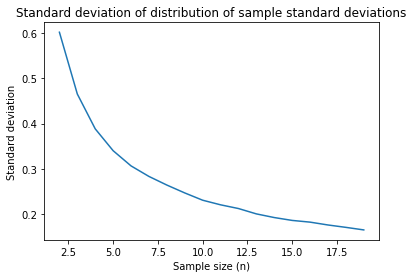

In [178]:
# Look at sample sizes from 2 to 19
nvals = np.array(range(2,20))

# Generate 10,0000 samples of each size, estimate the standard deviation from each sample,
# and then compute the standard deviation of our estimates. This tells us how widely
# our estimates vary.
stds = [np.random.randn(10000,n).std(axis=1, ddof=1).std(ddof=1) for n in nvals]

# Make a pretty picture. With labels.
plt.plot(nvals, stds)
plt.title("Standard deviation of distribution of sample standard deviations")
plt.xlabel("Sample size (n)")
plt.ylabel("Standard deviation")
plt.show()

## Empirical confidence intervals

As shown above, larger sample sizes have better estimates of the standard deviation, on average. Now let's look at how this effects confidence intervals for estimating the population mean from the sample mean. We'll generate samples from a standard normal, so we know that the true population mean is 0. The sample means are normally distributed, with mean 0 and standard deviation $1/\sqrt{n}$. However, when we don't know the standard deviation and we're estimating it from the sample, the standard error $\overline{x}/(s/\sqrt{n})$ is no longer normally distributed!

Let's generate a bunch of samples and see how it's actually distributed. We'll compute a z-score (using our sample mean and the true standard deviation of 1) and a t-score (using our sample mean and sample standard deviation) for the hypothesis $\mu = 0$, and look at the middle 95% of scores for each.

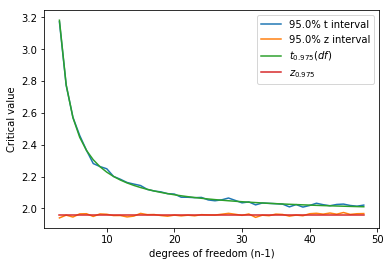

In [187]:
# alpha is the significance level (two-tailed)
alpha = 0.05

# q is the upper bound for a 2-tailed test with alpha
# For example, for 95% confidence interval (that is, alpha=0.05),
#   the lower percentile is 2.5% and the upper is 97.5%,
#   leaving 95% of the values in between.
q = 1 - alpha/2

# Compute empirical critical values for t and z distributions,
# using sample sizes from 4 to 49.
critical_t = []
critical_z = []
nvals = np.array(range(4,50))
for n in nvals:
    # Generate 100k samples, each of size n
    x = np.random.randn(100000, n)
    xbar = x.mean(axis=1)
    
    # When we use the estimated stddev, we have a t-score (dof=n-1)
    t_stderr = x.std(axis=1, ddof=1)/np.sqrt(n)
    tscore = xbar/t_stderr
    critical_t.append(np.percentile(tscore, 100*q))
    
    # When we use the true stddev (if known), we have a z-score
    z_stderr = 1.0/np.sqrt(n)   # True stddev is 1.
    zscore = xbar/z_stderr
    critical_z.append(np.percentile(zscore, 100*q))
    
# Plot empirical critical values for each sample size / number of degrees of freedom  
dof = nvals - 1
confidence = str(100 * (1-alpha))
plt.plot(dof, critical_t, label=confidence + '% t interval')
plt.plot(dof, critical_z, label=confidence + '% z interval')

# Plot the expected critical values, from the t and z distributions
# ppf(q) finds the critical value for the given probability.
# For example, st.norm.ppf(0.025) returns -1.96,
#   and st.norm.ppf(0.975) returns +1.96, which give you the critical
#   values for a 95% confidence interval
plt.plot(dof, st.t(dof).ppf(q), label=r'$t_{' + str(q) + r'}(df)$')
plt.plot(dof, [st.norm.ppf(q)] * dof.size, label=r'$z_{' + str(q) + r'}$')

plt.xlabel('degrees of freedom (n-1)')
plt.ylabel('Critical value')
plt.legend()
plt.show()

The empirical critical values match the expected ones almost exactly! Our simulation matches theory: the upper threshold for a 95% confidence interval matches a t-table or z-table, depending on if we computed it with the true or estimated standard deviation. Also, note that the z critical values don't depend on the degrees of freedom -- no matter how large or small your sample is, when the sample mean is normal, the critical value for a 95% confidence interval is 1.96.

## Plotting empirical and theoretical t-distributions

We've now shown that the critical values match. Let's generate some plots to look at the overall shape of our empirical t-distribution (generated from samples) with the probability density function (pdf) from `scipy.stats`. We can also compare the shape to a standard normal.

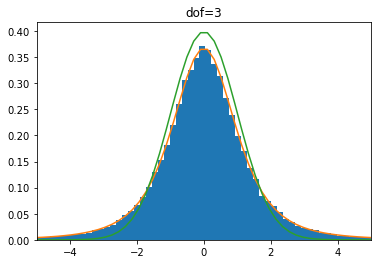

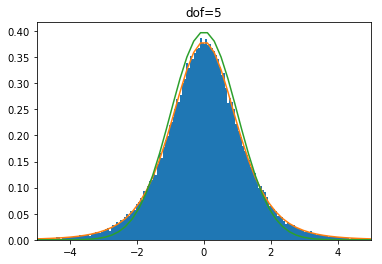

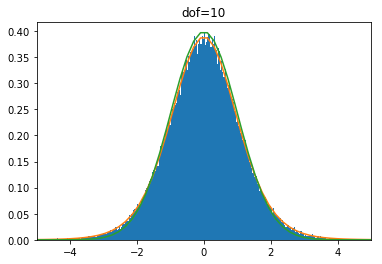

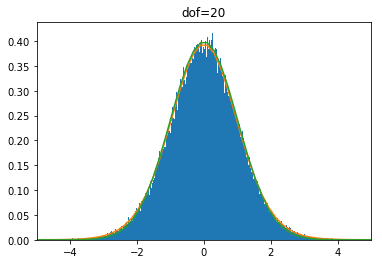

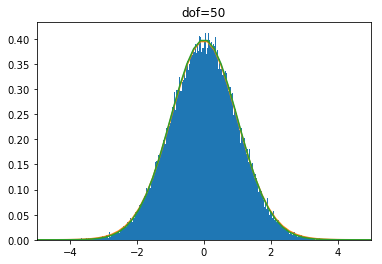

In [193]:
# Here are the sample sizes we'll consider (dof=n-1)
nvals = [4, 6, 11, 21, 51]

# We'll plot the range from -5 to 5.
xvals = np.linspace(-5,5)

for n in nvals:
    # Generate 100k samples, each of size n
    x = np.random.randn(100000, n)
    
    # Compute the t-score from each sample
    t_stderr = x.std(axis=1, ddof=1)/np.sqrt(n)
    tscore = x.mean(axis=1)/t_stderr
    
    # Plot a histogram for the 100,000 t-scores
    plt.hist(tscore, bins=500, normed=True)
    
    # Plot the t-distribution and standard normal on top
    plt.plot(xvals, st.t(n-1).pdf(xvals))
    plt.plot(xvals, st.norm.pdf(xvals))
    
    plt.title('dof=' + str(n-1))
    plt.xlim([-5,5])
    plt.show()

## Comparing t-distribution shapes

Finally, let's look at the shape of t-distributions with different degrees of freedom. As we increase the number of degrees of freedom, the shape approaches a standard normal distribution as expected.

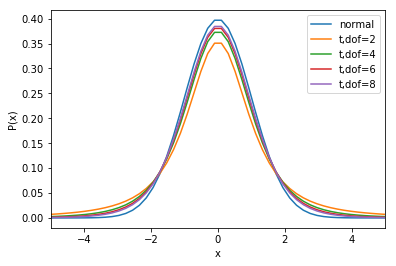

In [190]:
# Set the range of x-values to consider
x = np.linspace(-5,5)

# Plot a standard normal
plt.plot(x, st.norm.pdf(x), label='normal')

# Plot t-distributions with varied degrees of freedom.
for n in [2,4,6,8]:
    plt.plot(x, st.t(n).pdf(x), label='t,dof='+str(n))
    
plt.legend()
plt.xlabel('x')
plt.ylabel('P(x)')
plt.xlim([-5,5])
plt.show()